# Predicting which Canadian province will have the highest percentage of COVID-19 recoveries
### Group Members
Jason Ji (69217222), Mikayla Chau (29043288), Linda Zhang (95711800), Alireza Mohammadi (20700985)

In [1]:
set.seed(36)
library(tidyverse)
library(repr)
library(tidymodels)
options(repr.matrix.max.rows = 15)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.3.6     ✔ purrr   0.3.4
✔ tibble  3.1.7     ✔ dplyr   1.0.9
✔ tidyr   1.2.0     ✔ stringr 1.4.0
✔ readr   2.1.2     ✔ forcats 0.5.1

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

── Attaching packages ────────────────────────────────────── tidymodels 1.0.0 ──

✔ broom        1.0.0     ✔ rsample      1.0.0
✔ dials        1.0.0     ✔ tune         1.0.0
✔ infer        1.0.2     ✔ workflows    1.0.0
✔ modeldata    1.0.0     ✔ workflowsets 1.0.0
✔ parsnip      1.0.0     ✔ yardstick    1.0.0
✔ recipes      1.0.1     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filter()   masks stats::filter()
✖ recipes::fixed()  masks stringr::fixed()
✖ dplyr::lag()      masks stats::lag()
✖ yardstick::spec() masks r

### Intoduction

keeping columns: date, province, comfirmed, probable cases, deaths, total cases, percent today, percent recovered
predictors: date, comfirmed, probable cases, deaths, total cases, percent today
which province will be 

### Preliminary Data Analysis

The data is mostly tidy, however there are many columns we do not need for our analysis. Tidying the data included taking out these unwanted columns, any unwanted rows (Canada and Repatriated Travellers), and changing some column names to make it more reader-friendly. 

In [2]:
covid <- read_csv("canada-covid-19.csv")
covid

Rows: 9762 Columns: 40
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr   (3): prname, prnameFR, percentrecover
dbl  (36): pruid, update, numconf, numprob, numdeaths, numtotal, numtested, ...
date  (1): date

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


pruid,prname,prnameFR,date,update,numconf,numprob,numdeaths,numtotal,numtested,⋯,ratedeaths_last14,numtotal_last7,ratetotal_last7,numdeaths_last7,ratedeaths_last7,avgtotal_last7,avgincidence_last7,avgdeaths_last7,avgratedeaths_last7,raterecovered
<dbl>,<chr>,<chr>,<date>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
35,Ontario,Ontario,2020-01-31,NA,3,0,0,3,NA,⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,0
59,British Columbia,Colombie-Britannique,2020-01-31,NA,1,0,0,1,NA,⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,0
1,Canada,Canada,2020-01-31,NA,4,0,0,4,NA,⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,0
35,Ontario,Ontario,2020-02-08,NA,3,0,0,3,NA,⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,0
59,British Columbia,Colombie-Britannique,2020-02-08,NA,4,0,0,4,NA,⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,0
1,Canada,Canada,2020-02-08,NA,7,0,0,7,NA,⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,0
35,Ontario,Ontario,2020-02-16,NA,3,0,0,3,NA,⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,0
59,British Columbia,Colombie-Britannique,2020-02-16,NA,5,0,0,5,NA,⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,0
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋱,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮


In [3]:
tidy_covid <- covid |> 
    mutate(province = prname) |>
    mutate(percentrecover = as.numeric(percentrecover)) |>
    select(province, date, numconf, numprob, numdeaths, numtotal, percentrecover) |>
    filter(province != "Repatriated travellers") |>
    filter(province != "Canada") |>
    group_by(province)
tidy_covid

Warning message in mask$eval_all_mutate(quo):
“NAs introduced by coercion”


province,date,numconf,numprob,numdeaths,numtotal,percentrecover
<chr>,<date>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
Ontario,2020-01-31,3,0,0,3,NA
British Columbia,2020-01-31,1,0,0,1,NA
Ontario,2020-02-08,3,0,0,3,NA
British Columbia,2020-02-08,4,0,0,4,NA
Ontario,2020-02-16,3,0,0,3,NA
British Columbia,2020-02-16,5,0,0,5,NA
Ontario,2020-02-21,3,0,0,3,NA
British Columbia,2020-02-21,6,0,0,6,NA
⋮,⋮,⋮,⋮,⋮,⋮,⋮


In [4]:
covid_split <- initial_split(tidy_covid, prop = 0.75, strata = province)
covid_train <- training(covid_split)
covid_test <- testing(covid_split)
covid_train
covid_test

Warning message:
“Too little data to stratify.
• Resampling will be unstratified.”


province,date,numconf,numprob,numdeaths,numtotal,percentrecover
<chr>,<date>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
Ontario,2020-01-31,3,0,0,3,NA
British Columbia,2020-01-31,1,0,0,1,NA
Ontario,2020-02-16,3,0,0,3,NA
Ontario,2020-02-21,3,0,0,3,NA
British Columbia,2020-02-21,6,0,0,6,NA
Ontario,2020-02-25,4,0,0,4,NA
British Columbia,2020-02-25,7,0,0,7,NA
Ontario,2020-02-26,5,0,0,5,NA
⋮,⋮,⋮,⋮,⋮,⋮,⋮


province,date,numconf,numprob,numdeaths,numtotal,percentrecover
<chr>,<date>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
Ontario,2020-02-08,3,0,0,3,NA
British Columbia,2020-02-08,4,0,0,4,NA
British Columbia,2020-02-16,5,0,0,5,NA
Ontario,2020-02-24,4,0,0,4,NA
British Columbia,2020-02-24,6,0,0,6,NA
Ontario,2020-02-27,6,0,0,6,NA
Ontario,2020-02-29,8,0,0,8,NA
Ontario,2020-03-01,15,0,0,15,NA
⋮,⋮,⋮,⋮,⋮,⋮,⋮


Summary Tables

In [5]:
obs_num_summary <- group_by(covid_train, province)%>%
                            summarize( 
                             min_conf = min(numconf, na.rm = TRUE),
                             mean_conf = mean(numconf,na.rm = TRUE),
                             most_conf = max(numconf, na.rm = TRUE),
                             min_death = min(numdeaths, na.rm = TRUE),
                             mean_death = mean(numdeaths,na.rm = TRUE),
                             most_death = max(numdeaths, na.rm = TRUE),
                             min_total = min(numtotal, na.rm = TRUE),
                             mean_death = mean(numtotal,na.rm = TRUE),
                             most_total = max(numtotal, na.rm = TRUE),
                             )
obs_num_summary

province,min_conf,mean_conf,most_conf,min_death,mean_death,most_death,min_total,most_total
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
Alberta,14,130984.1076,341023,0,130976.3566,3286,14,341023
British Columbia,1,78322.5764,225785,0,78322.5764,2399,1,225785
Manitoba,0,28092.2475,70539,0,28095.1724,1359,0,70539
New Brunswick,0,1689.8403,9973,0,1689.9139,144,0,9973
Newfoundland and Labrador,0,828.4609,2152,0,828.4835,18,0,2152
Northwest Territories,0,272.9243,2082,0,272.9243,12,0,2082
Nova Scotia,0,2963.5144,9202,0,2963.5823,110,0,9202
Nunavut,0,310.0397,676,0,310.0397,4,0,676
Ontario,3,270338.0020,642465,0,270338.0020,10107,3,642465


In [6]:
province_obs <- group_by(covid_train,province)%>%
summarize(num_obs=n())
province_obs

province,num_obs
<chr>,<int>
Alberta,502
British Columbia,484
Manitoba,493
New Brunswick,476
Newfoundland and Labrador,486
Northwest Territories,502
Nova Scotia,486
Nunavut,479
Ontario,495


In [7]:
missing <- covid_train %>% summarise_all(~ sum(is.na(.)))
missing

province,date,numconf,numprob,numdeaths,numtotal,percentrecover
<chr>,<int>,<int>,<int>,<int>,<int>,<int>
Alberta,0,0,181,0,0,22
British Columbia,0,0,164,0,0,23
Manitoba,0,0,177,0,0,23
New Brunswick,0,0,167,0,0,22
Newfoundland and Labrador,0,0,170,0,0,20
Northwest Territories,0,0,182,0,0,28
Nova Scotia,0,0,166,0,0,21
Nunavut,0,0,170,0,0,180
Ontario,0,0,166,0,0,30


Visualization

Warning message:
“Removed 461 rows containing missing values (position_stack).”


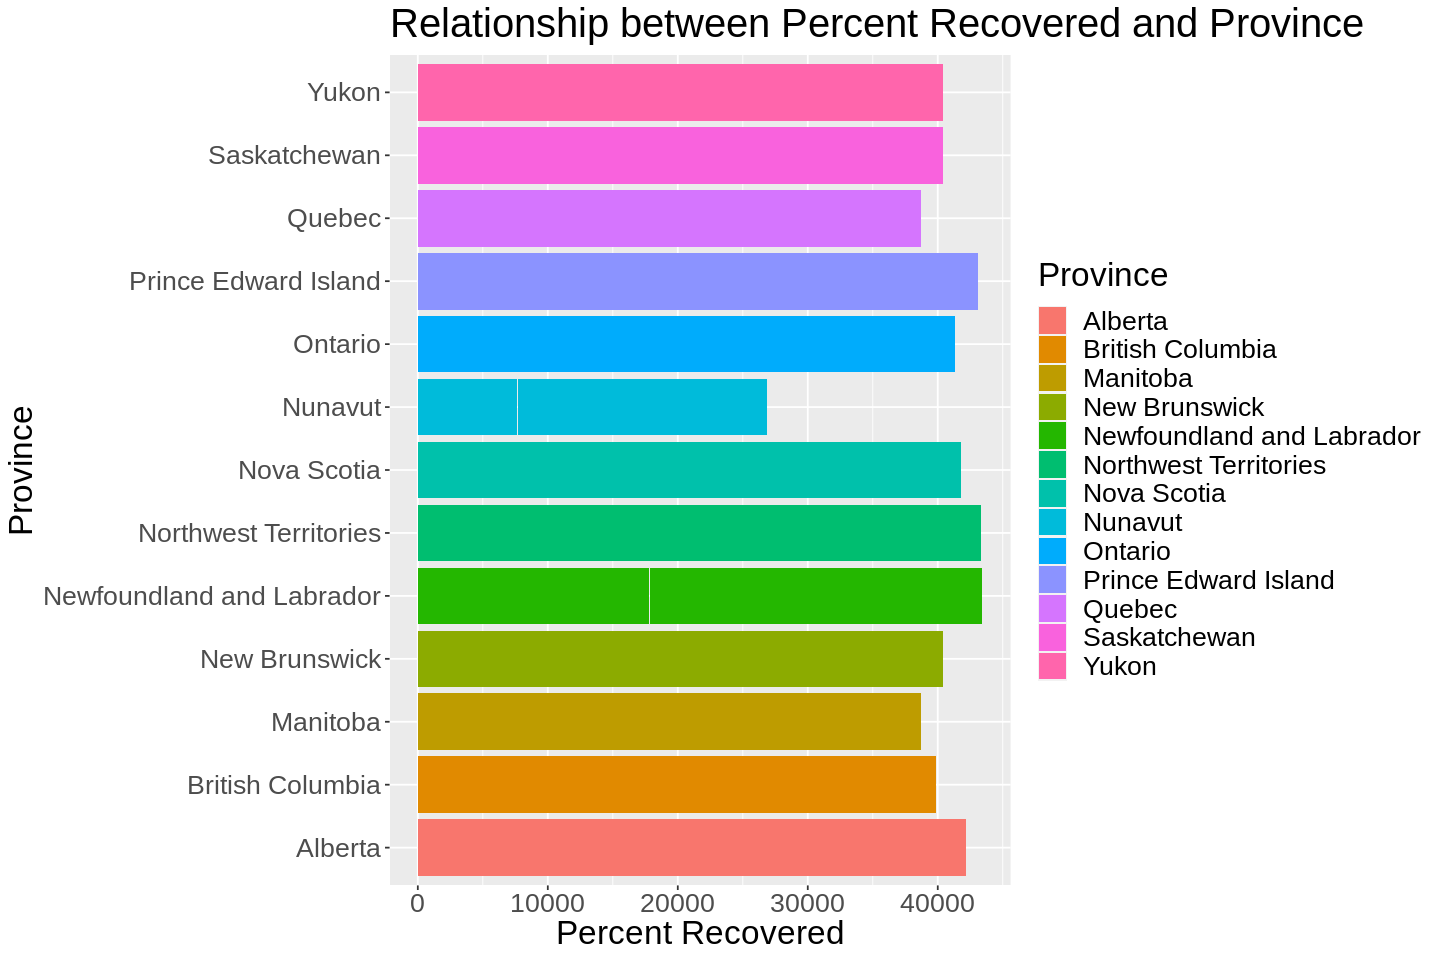

In [21]:
options(repr.plot.width = 12, repr.plot.height = 8)
recover_plot <- covid_train |> 
    ggplot(aes(x = province, y = percentrecover, fill = province)) +
        geom_bar(stat = "identity")+
        labs(x = "Province", y = "Percent Recovered", fill = "Province")+
        coord_flip()+
        theme(text = element_text(size = 20))+
    ggtitle("Relationship between Percent Recovered and Province")
recover_plot